# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from importlib import reload 
import h5py
from utils import *
import time
import json
import tensorflow as tf
from IPython.display import clear_output
import tensorflow as tf
from vae_models import *

tf.config.set_soft_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1D Facies Model Markov Generation

(48, 1)


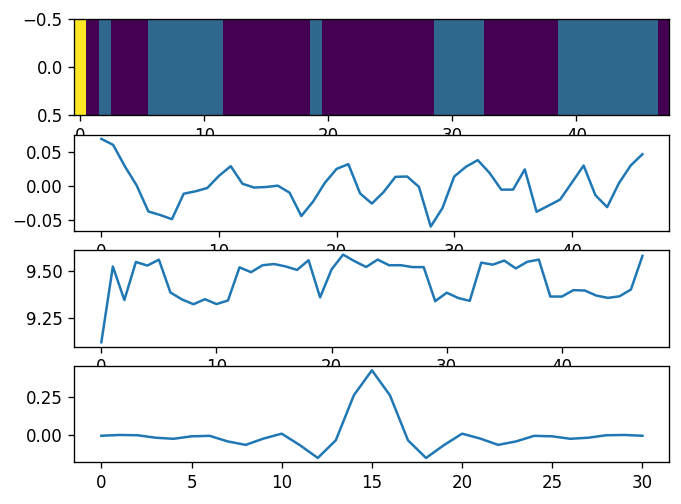

In [2]:
## Prior parameter ##
nl_level = 10

PRIOR = np.ones(4, dtype=[('MU', float, (4)), ('C', float, (4,4))])

mu = np.ones([4,4])
mu[0] = [8.5948, 8.0356, 0.9613, 9.5561]
mu[1] = [8.4563, 7.8829, 0.9186, 9.3749]
mu[2] = [8.6676, 8.0483, 1.0716, 9.7392]
mu[3] = [8.4136, 7.8345, 0.7348, 9.1484]
#print(mu)

c = np.ones([4,4,4])
c[0,:] = [[0.0037, 0.0027, 0.0008, 0.0000],
            [0.0027, 0.0030, 0.0008, 0.0000],
            [0.0008, 0.0008, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0111]]

c[1,:] = [[0.0032, 0.0028, 0.0011, 0.0000],
            [0.0028, 0.0033, 0.0010, 0.0000],
            [0.0011, 0.0010, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0096]]

c[2,:] = [[0.0023, 0.0016, 0.0008, 0.0000],
            [0.0016, 0.0017, 0.0007, 0.0000],
            [0.0008, 0.0007, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0070]]

c[3,:] = [[0.0008, 0.0005, 0.0003, 0.0000],
            [0.0005, 0.0004, 0.0002, 0.0000],
            [0.0003, 0.0002, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0023]]
#print(c)

wavelet_new = [-1039.55055580727,
            -4026.57620068033,
            -8194.18572794536,
            -11356.0387947636,
            -11906.6435543803,
            -10191.4389229172,
            -8639.29324618705,
            -10474.3682826362,
            -17093.5087710456,
            -25733.4288332681,
            -29906.2345220425,
            -23088.0727988944,
            -3091.80943987738,
            25306.1208726887,
            51180.4184438887,
            63288.5822013372,
            53619.9099732780,
            32940.2018555759,
            11743.5370194762,
            -3175.56289063239,
            -10845.0261972202,
            -13246.6910319655,
            -12569.5536619989,
            -10329.2514738468,
            -7512.57465309683,
            -5018.31852539635,
            -3551.82629919458,
            -3000.47980521376,
            -2436.41725067266,
            -1305.36051838710,
            -346.558408174331]

PRIOR['MU'] = mu
PRIOR['C'] = c

## Geracao do ensemble ##
n = 48
I = n
J = 1
signal2noise = 5
v_fact = 0.1

wavelet = np.array(wavelet_new)

delta = np.zeros([31,1])
delta[np.around(delta.shape[0]/2).astype(int)-1,0] = 1

wavelet = lowPassFilter2(delta,4,40,60) - lowPassFilter2(delta,4,40,6)

G = acoustic_foward_matrix(wavelet,I)

#P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.array(P)

facies = simulate_markov_chain(P,n,3,1)
print(facies.shape)
mu, log_imp, seismic = facies_forward_model(facies, PRIOR, G, v_fact)

noise = np.random.randn(I-1,1)
noise = noise/np.std(noise)
std_noise = np.std(seismic)/np.sqrt(signal2noise)
noise = noise*std_noise
seismic = seismic + noise.ravel()

fig, axs = plt.subplots(4)
fig.set_dpi(120)
axs[0].imshow(facies.transpose(), aspect='auto')
axs[1].plot(seismic)
axs[2].plot(log_imp)
axs[3].plot(wavelet)
plt.show()

# 2D Facies Model Markov Generation

C:\Users\rodri\AppData\Local\Temp\ipykernel_52772\4163793594.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


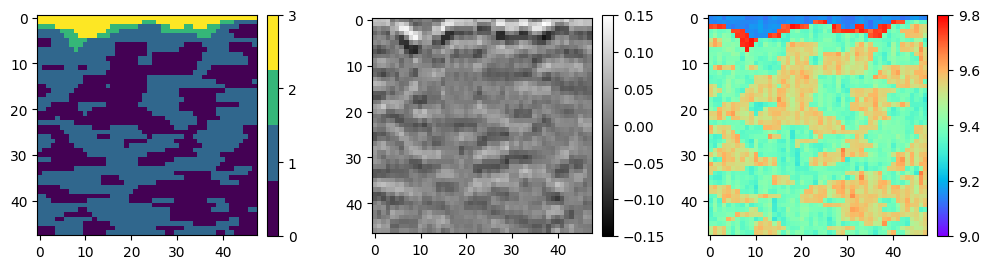

In [3]:
from scipy.ndimage.filters import gaussian_filter

#Pver = np.array(np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.066 0.066 0.066 0.802'))
Pver = np.array(np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.15 0.15 0.15 0.55'))

Phor = np.array(np.matrix('0.4 0.4 0.1 0.1; 0.4 0.4 0.1 0.1; 0.1 0.1 0.6 0.2; 0.1 0.1 0.2 0.6'))

#Simulation grid size

I = 48
J = 48
initial_facies = 3

prior_map = np.ones([I, J, 4])

simulation = simulate_markov_2Dchain(Phor, Pver, prior_map, initial_facies)
ss = gaussian_filter(simulation, sigma=[0.5, 1.5])
st = simulation == 3
ss[st] = 3
ss = np.round(gaussian_filter(ss, sigma=[0.5 , 1.5]))

def facies_forward_model_2D(facies, PRIOR, G, v_fact):
  seismics = []
  impedances = []
  for j in range(0,J):
    mu, log_imp, seismic = facies_forward_model(facies[:,j], PRIOR, G, v_fact)
    seismics.append(seismic)
    impedances.append(log_imp)

  seismics = np.array(seismics).transpose()
  impedances = np.array(impedances).transpose()
  return seismics, impedances

seis, immp = facies_forward_model_2D(ss, PRIOR, G, v_fact)

cmap_viridis_dicrete = plt.get_cmap('viridis', 4)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
plt.colorbar(axes[0].imshow(ss, cmap=cmap_viridis_dicrete), ticks=np.linspace(0,3,4), fraction=0.046, pad=0.04)
plt.colorbar(axes[1].imshow(seis, cmap='gray', vmin=-0.15, vmax=0.15), fraction=0.046, pad=0.04)
plt.colorbar(axes[2].imshow(immp, cmap='rainbow', vmin=9.0, vmax=9.8), fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, AxesGrid


fig = plt.figure(figsize=(6, 8), dpi=100)

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
cmap_viridis_dicrete = plt.get_cmap('viridis', 4)
simulations = []
count = 0
for ax in grid:
    simulation = simulate_markov_2Dchain(Phor, Pver, prior_map, initial_facies)
    simulations.append(simulation)
    im = ax.imshow(simulation, cmap=cmap_viridis_dicrete, interpolation='None')
    count = count + 1
    ax.xaxis.set_ticks(np.arange(0, 48, 10))
    ax.yaxis.set_ticks(np.arange(0, 48, 10))
    for it in ax.get_xticklabels():
        it.set_fontsize(5)
    for it in ax.get_yticklabels():
        it.set_fontsize(5)

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.linspace(0,3,4), fontsize=18)
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
plt.tight_layout()
plt.savefig("markov_samples.png",bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(figsize=(6, 8), dpi=100)

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
cmap_viridis_dicrete = plt.get_cmap('viridis', 4)

count = 0
for ax in grid:
    ss = gaussian_filter(simulations[count], sigma=[0.5, 1.5])
    st = simulation == 3
    ss[st] = 3
    ss = np.round(gaussian_filter(ss, sigma=[0.5 , 1.5]))
    im = ax.imshow(ss, cmap=cmap_viridis_dicrete, interpolation='None')
    count = count + 1
    ax.xaxis.set_ticks(np.arange(0, 48, 10),fontsize=14)
    ax.yaxis.set_ticks(np.arange(0, 48, 10),fontsize=14)
    for it in ax.get_xticklabels():
        it.set_fontsize(5)
    for it in ax.get_yticklabels():
        it.set_fontsize(5)

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.linspace(0,3,4),fontsize=18)
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0.1, wspace = 0)
# plt.margins(0,0)
plt.tight_layout()
plt.savefig("samples_filtered.png",bbox_inches='tight',pad_inches=0)

plt.show()

# Load Datset

In [4]:

hf = h5py.File('data_48x48_2D.h5', 'r')
X_bk = np.array(hf['X'])
hf.close()
print(X_bk.shape)
X = np.copy(X_bk)
X = tf.keras.utils.to_categorical(X, num_classes=4)
print(X.shape)

(50000, 48, 48)
(50000, 48, 48, 4)


# Train DL models

In [ ]:
fpath="redes/"

csv_logger = tf.keras.callbacks.CSVLogger(fpath+"vae_history.csv", append=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fpath+"vae_f/", verbose=1)

class SampleImgs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rn = tf.random.normal(shape=[4, vae.latent_dim])
        fig,axs = plt.subplots(1,4, figsize=(8,6))
        for i in range(0,4):
            axs[i].imshow(vae.decode(rn)[i])
        plt.show()

vae = VAE(lat_size=12*12*3)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
history = vae.fit(X, epochs=100, batch_size=8, callbacks=[SampleImgs(), csv_logger, cp_callback])
tf.keras.models.save_model(vae.encoder, fpath+"vae_f/encoder")
tf.keras.models.save_model(vae.decoder, fpath+"vae_f/decoder")

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger(fpath+"fcvae_history.csv", append=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fpath+"fcvae_f/",verbose=1)


class ViewReconstruction(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rnd = random.randint(0, X.shape[0]-1)
        rnd_img = tf.expand_dims(X[0], axis=0)
        z_mean, z_log_var, z = fcvae.encoder(rnd_img)
        fig,axs = plt.subplots(1,4, figsize=(6,4))
        #axs[0].imshow((rnd_img)[0])
        #axs[1].imshow(np.around(fcvae.decoder(z)[0]*3))
        axs[0].imshow(np.argmax((rnd_img)[0], axis=-1))
        axs[1].imshow(fcvae.decode(z)[0])
        axs[2].hist(z.numpy().flatten())
        axs[3].imshow(z.numpy().reshape((fcvae.latent_dim,fcvae.latent_dim)))
        fig.tight_layout()
        plt.show()

class SampleImgs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rn = tf.random.normal(shape=[4, fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])
        fig,axs = plt.subplots(1,4, figsize=(8,6))
        for i in range(0,4):
            axs[i].imshow(fcvae.decode(rn)[i])
        plt.show()

fcvae = FCVAE(lat_size=3)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
learningRateScheduler = tf.keras.callbacks.LearningRateScheduler(fcvae.step_decay,verbose=0)
fcvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
fcvae.fit(X, epochs=100, batch_size=8, callbacks=[SampleImgs(), csv_logger, cp_callback])
tf.keras.models.save_model(fcvae.encoder, fpath+"fcvae_f/encoder")
tf.keras.models.save_model(fcvae.decoder, fpath+"fcvae_f/decoder")

# Load DL models

In [5]:
fpath="redes/"

In [6]:
vae = VAE(lat_size=12*12*3)
vae.encoder = tf.keras.models.load_model(fpath+"vae_f/encoder")
vae.decoder = tf.keras.models.load_model(fpath+"vae_f/decoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 12, 16)   4624        conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
fcvae.decoder.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_6')>]

In [7]:
fcvae = FCVAE(lat_size=3)
fcvae.encoder = tf.keras.models.load_model(fpath+"fcvae_f/encoder")
fcvae.decoder = tf.keras.models.load_model(fpath+"fcvae_f/decoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 3232        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 25632       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 6 51264       conv2d_4[0][0]                   
____________________________________________________________________________________________

# Latent space manipulation

In [ ]:
idxi = 100
idx = 0
encx = fcvae.encoder(X[idxi:idxi+1])[0].numpy()
ench_or = fcvae.decode(encx)[0]
encx[:,idx,idx+5,:] = encx[:,idx,idx+5,:]-100
ench = fcvae.decode(encx)[0]
fig, axs = plt.subplots(1,4, figsize=(6,4))
axs[0].imshow(ench_or)
axs[1].imshow(np.mean(encx, axis=-1)[0],cmap='YlOrBr',vmin=-10, vmax=1)
axs[2].imshow(ench)
axs[3].imshow(ench_or==ench)
plt.show()


In [ ]:
fig= plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(ench_or, cmap=cmap_viridis_dicrete), shrink=0.8)
cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'], fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#fig.colorbar(plt.imshow(diff, cmap='seismic'))
fig.savefig('original_input.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

fig = plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(np.mean(fcvae.encoder(X[idxi:idxi+1])[0].numpy(), axis=-1)[0]*-1,cmap='coolwarm',vmin=-1, vmax=1), shrink=0.8)
cbar.ax.set_yticks(np.linspace(-1,1,5))
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#fig.colorbar(plt.imshow(diff, cmap='seismic'))
fig.savefig('original_latent.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

fig = plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(ench_or, cmap=cmap_viridis_dicrete), shrink=0.8)
cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'],fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#fig.colorbar(plt.imshow(diff, cmap='seismic'))
fig.savefig('original_output.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

fig = plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(np.mean(encx, axis=-1)[0]*-1,cmap='coolwarm',vmin=-1, vmax=1), shrink=0.8)
cbar.ax.set_yticks(np.linspace(-1,1,5))
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#fig.colorbar(plt.imshow(diff, cmap='seismic'))
fig.savefig('modified_latent.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

fig = plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(ench, cmap=cmap_viridis_dicrete), shrink=0.8)
cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'],fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#fig.colorbar(plt.imshow(diff, cmap='seismic'))
fig.savefig('modified_output.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

binary_dicrete = plt.get_cmap('binary',2)
fig = plt.figure(dpi=100, figsize=(6,6))
#fig = plt.figure(dpi=100)
cbar = fig.colorbar(plt.imshow(ench == ench_or, cmap=binary_dicrete), shrink=0.8)
cbar.ax.set_yticks(np.linspace(0,1,2))
cbar.ax.set_yticklabels(['Not-Equal', 'Equal'], fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig('diff_output.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Sampling example

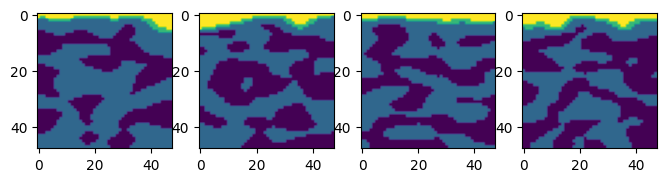

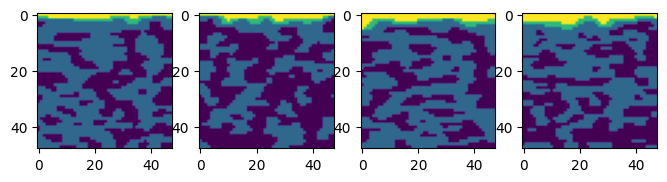

In [9]:
rn = tf.random.normal(shape=[4, vae.latent_dim])

fig,axs = plt.subplots(1,4, figsize=(8,6))
gens_imgs = vae.decode(rn)
for i in range(0,4):
    axs[i].imshow(gens_imgs[i])
plt.show()

rn = tf.random.normal(shape=[4, fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])

fig,axs = plt.subplots(1,4, figsize=(8,6))
gens_imgs = fcvae.decode(rn)
for i in range(0,4):
    axs[i].imshow(gens_imgs[i])
plt.show()

# ES-MDA with DL

In [10]:
ss = np.load('facies_reference.npy')

### ES-MDA-FCVAE

In [11]:
from ES_MDA import *

Na = 20
Ne = 1000

mr = ss.reshape(1,n,n,1)

G = acoustic_foward_matrix(wavelet,I)

seis_exp, imp_exp = facies_forward_model_2D(mr.reshape(n,n),PRIOR,G, v_fact)

seis_exp = seis_exp.reshape(-1)

noise = np.random.randn((I-1)*J)
noise = noise/np.std(noise)
std_noise = np.std(seis_exp)/np.sqrt(signal2noise)
noise = noise*std_noise
seis_exp = seis_exp + noise

seis_exp.reshape([47,48])

C_d = std_noise**2*tf.eye(seis_exp.shape[0])


obs = seis_exp.reshape([-1,1])

m_x = fcvae.encoder(X[:Ne])[0].numpy()
m_f = np.argmax(fcvae.decoder(m_x).numpy(), axis=-1).reshape([m_x.shape[0],-1])

m_f_a, m_x_a, m_f_a_i, error_a = ES_MDA_DL(Na,[],obs,C_d,m_x.T, m_f.T,[48,48],PRIOR, G, fcvae)

Error iteration 0  :  80996.52742679307
Error iteration 1  :  64174.33098049802
Error iteration 2  :  57783.97406123694
Error iteration 3  :  53535.932505086006
Error iteration 4  :  50756.07374421223
Error iteration 5  :  48664.34207478605
Error iteration 6  :  46831.75106984917
Error iteration 7  :  45326.5603747361
Error iteration 8  :  44190.82696792775
Error iteration 9  :  43153.67513993616
Error iteration 10  :  42415.27167359108
Error iteration 11  :  41653.61906878055
Error iteration 12  :  41050.49504912495
Error iteration 13  :  40647.42712772214
Error iteration 14  :  40198.62866114679
Error iteration 15  :  39825.617556828074
Error iteration 16  :  39520.23095997457
Error iteration 17  :  39221.93883523381
Error iteration 18  :  38933.03886269346
Error iteration 19  :  38666.49356506034
Error iteration 20  :  38480.48963520826


### ES-MDA-VAE

In [12]:
Na = 20
Ne = 1000

mr = ss.reshape(1,n,n,1)

G = acoustic_foward_matrix(wavelet,I)

seis_exp, imp_exp = facies_forward_model_2D(mr.reshape(n,n),PRIOR,G, v_fact)

seis_exp = seis_exp.reshape(-1)

noise = np.random.randn((I-1)*J)
noise = noise/np.std(noise)
std_noise = np.std(seis_exp)/np.sqrt(signal2noise)
noise = noise*std_noise
seis_exp = seis_exp + noise

seis_exp.reshape([47,48])

C_d = std_noise**2*tf.eye(seis_exp.shape[0])


obs = seis_exp.reshape([-1,1])

m_x_vae = vae.encoder(X[:Ne])[0].numpy()
m_f_vae = np.argmax(vae.decoder(m_x_vae).numpy(), axis=-1).reshape([m_x_vae.shape[0],-1])

m_f_a_vae, m_x_a_vae, m_f_a_i_vae, error_a_vae = ES_MDA_DL(Na,[],obs,C_d,m_x_vae.T, m_f_vae.T,[48,48],PRIOR, G, vae)

Error iteration 0  :  77284.62823615014
Error iteration 1  :  68693.29572057644
Error iteration 2  :  64405.57962143526
Error iteration 3  :  62020.456933010944
Error iteration 4  :  59860.68297524652
Error iteration 5  :  58019.70903022047
Error iteration 6  :  56321.28755748003
Error iteration 7  :  55024.741279986454
Error iteration 8  :  53948.13436026916
Error iteration 9  :  53027.1302092076
Error iteration 10  :  52221.68565580025
Error iteration 11  :  51422.029461653736
Error iteration 12  :  50599.824416628
Error iteration 13  :  50025.60087992625
Error iteration 14  :  49444.59458005256
Error iteration 15  :  48903.88278109334
Error iteration 16  :  48321.727887602916
Error iteration 17  :  47994.9270078776
Error iteration 18  :  47659.463569382424
Error iteration 19  :  47325.97351909075
Error iteration 20  :  47058.892846348375


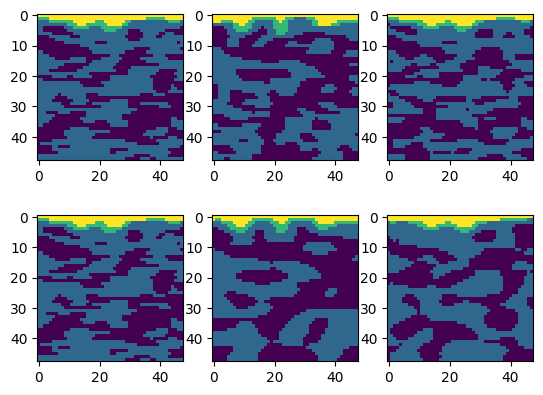

In [13]:
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(tf.reshape(mr,[n,n]))
axs[0,1].imshow(m_f.T.reshape([48,48,Ne])[:,:,0])
axs[0,2].imshow(m_f_a.reshape([48,48,Ne])[:,:,0])
axs[1,0].imshow(tf.reshape(mr,[n,n]))
axs[1,1].imshow(m_f_vae.T.reshape([48,48,Ne])[:,:,0])
axs[1,2].imshow(m_f_a_vae.reshape([48,48,Ne])[:,:,0])
plt.show()

In [31]:
Obs_sim,_ = get_obs_sim(m_x_a[0].T,[48,48],PRIOR,G,fcvae)

In [32]:
Obs_simp,_ = get_obs_sim(m_x_a[-1].T,[48,48],PRIOR,G,fcvae)

In [29]:
Obs_sim.T.shape

(2256, 1000)

In [30]:
obs.shape

(2256, 1)

In [35]:
(Obs_sim.T - np.repeat(obs,Obs_sim.T.shape[-1],axis=1) ** 2).mean(axis=1).mean()

-5.8234987406258406e-05

In [36]:
(Obs_simp.T - np.repeat(obs,Obs_simp.T.shape[-1],axis=1) ** 2).mean(axis=1).mean()

-0.0002356190756809212

In [40]:
tf.keras.losses.mse(np.repeat(obs,Obs_sim.T.shape[-1],axis=1), Obs_sim.T).numpy().mean()

0.0013649782295286387

In [39]:
tf.keras.losses.mse(np.repeat(obs,Obs_simp.T.shape[-1],axis=1), Obs_simp.T).numpy().mean()

0.0005595079938479343

In [27]:
error_seis = []
error_seis_vae = []
for i in range(Na):
    Obs_sim,_ = get_obs_sim(m_x_a[i].T,[48,48],PRIOR,G,fcvae)
    error_seis.append(tf.keras.losses.mse(np.repeat(obs,Obs_sim.T.shape[-1],axis=1), Obs_sim.T).numpy().mean())
    Obs_sim,_ = get_obs_sim(m_x_a_vae[i].T,[48,48],PRIOR,G,vae)
    error_seis_vae.append(tf.keras.losses.mse(np.repeat(obs,Obs_sim.T.shape[-1],axis=1), Obs_sim.T).numpy().mean())
    print("Iteration {}: MSE seismic -> FCVAE {:.4f}, VAE {:.4f}".format(i,error_seis[-1], error_seis_vae[-1]))

Iteration 0: MSE seismic -> FCVAE 0.0238, VAE 0.0215
Iteration 1: MSE seismic -> FCVAE 0.0249, VAE 0.0219
Iteration 2: MSE seismic -> FCVAE 0.0254, VAE 0.0222
Iteration 3: MSE seismic -> FCVAE 0.0258, VAE 0.0223
Iteration 4: MSE seismic -> FCVAE 0.0260, VAE 0.0225


KeyboardInterrupt: 

In [14]:
mse_fcvae = []
std_fcvae = []
mse_vae = []
std_vae = []
for i in range(Na):
    mse_fcvae.append((abs(m_f_a_i[i] - np.repeat(mr.reshape(-1,1),m_f_a_i[i].shape[-1],axis=1)) ** 2).mean(axis=1).mean())
    mse_vae.append((abs(m_f_a_i_vae[i] - np.repeat(mr.reshape(-1,1),m_f_a_i_vae[i].shape[-1],axis=1)) ** 2).mean(axis=1).mean())
    std_fcvae.append(m_f_a_i[i].var(axis=-1).mean())
    std_vae.append(m_f_a_i_vae[i].var(axis=-1).mean())
    print("Iteration {}: MSE -> FCVAE {:.4f}, VAE {:.4f} | Std -> FCVAE {:.4f}, VAE {:.4f}".format(i,mse_fcvae[-1], mse_vae[-1], std_fcvae[-1], std_vae[-1]))
#print(mse_fcvae, mse_vae)

Iteration 0: MSE -> FCVAE 0.3826, VAE 0.4068 | Std -> FCVAE 0.2103, VAE 0.2081
Iteration 1: MSE -> FCVAE 0.3287, VAE 0.3671 | Std -> FCVAE 0.1721, VAE 0.1726
Iteration 2: MSE -> FCVAE 0.2883, VAE 0.3375 | Std -> FCVAE 0.1472, VAE 0.1479
Iteration 3: MSE -> FCVAE 0.2620, VAE 0.3162 | Std -> FCVAE 0.1283, VAE 0.1288
Iteration 4: MSE -> FCVAE 0.2413, VAE 0.3040 | Std -> FCVAE 0.1127, VAE 0.1116
Iteration 5: MSE -> FCVAE 0.2247, VAE 0.2969 | Std -> FCVAE 0.0996, VAE 0.0973
Iteration 6: MSE -> FCVAE 0.2120, VAE 0.2965 | Std -> FCVAE 0.0889, VAE 0.0865
Iteration 7: MSE -> FCVAE 0.2036, VAE 0.2922 | Std -> FCVAE 0.0803, VAE 0.0776
Iteration 8: MSE -> FCVAE 0.1942, VAE 0.2885 | Std -> FCVAE 0.0717, VAE 0.0717
Iteration 9: MSE -> FCVAE 0.1881, VAE 0.2883 | Std -> FCVAE 0.0652, VAE 0.0644
Iteration 10: MSE -> FCVAE 0.1842, VAE 0.2871 | Std -> FCVAE 0.0592, VAE 0.0573
Iteration 11: MSE -> FCVAE 0.1817, VAE 0.2867 | Std -> FCVAE 0.0546, VAE 0.0513
Iteration 12: MSE -> FCVAE 0.1792, VAE 0.2846 | St

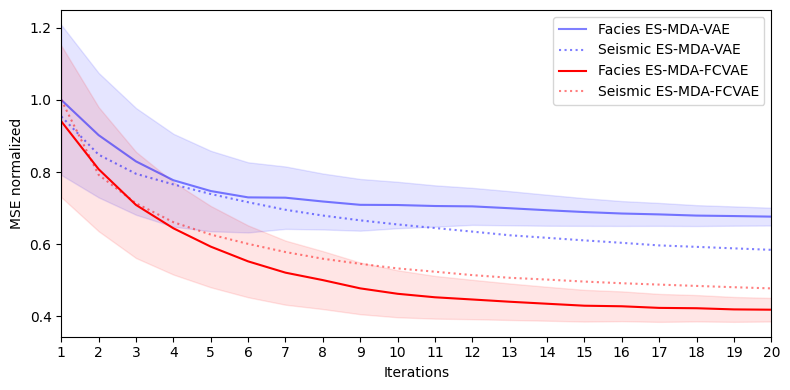

In [19]:
m_loss_vae = np.array(mse_vae)
seismic_loss_vae = np.array(error_a_vae[:-1])
#imp_loss_vae = np.array(data_vae['dimp_obs_loss'])
ens_std_vae = np.array(std_vae)

m_loss_fcvae = np.array(mse_fcvae)
seismic_loss_fcvae = np.array(error_a[:-1])
#imp_loss_fcvae = np.array(data_fcvae['dimp_obs_loss'])
ens_std_fcvae = np.array(std_fcvae)

max_loss = max(m_loss_vae.max(), m_loss_fcvae.max())
max_seismic_loss = max(seismic_loss_vae.max(), seismic_loss_fcvae.max())
#max_impedance_loss = max(imp_loss_vae.max(), imp_loss_fcvae.max())

fig = plt.figure(figsize=(8, 4), dpi=100)

plt.plot(np.arange(1, 21, step=1), m_loss_vae/max_loss, linestyle='-', color='b', label='Facies ES-MDA-VAE', alpha=0.5)
plt.fill_between(np.arange(1, 21, step=1),m_loss_vae/max_loss-ens_std_vae,m_loss_vae/max_loss+ens_std_vae,color='b',alpha=.1)

plt.plot(np.arange(1, 21, step=1), seismic_loss_vae/max_seismic_loss,  linestyle=':', color='b', label='Seismic ES-MDA-VAE', alpha=0.5)
plt.plot(np.arange(1, 21, step=1), m_loss_fcvae/max_loss, linestyle='-', color='r', label='Facies ES-MDA-FCVAE')
plt.fill_between(np.arange(1, 21, step=1),m_loss_fcvae/max_loss-ens_std_fcvae,m_loss_fcvae/max_loss+ens_std_fcvae,color='r',alpha=.1)
plt.plot(np.arange(1, 21, step=1),seismic_loss_fcvae/max_seismic_loss, linestyle=':', color='r', label='Seismic ES-MDA-FCVAE', alpha=0.5)
plt.xticks(np.arange(0, 31, step=1))
plt.xlim([1, 20])

#plt.plot(m_loss_vae, color='r', label='model')
#plt.plot(m_loss_fcvae, '--', color='r', label='model')
#plt.plot(seismic_loss_vae/max_seismic_loss, color='g', label='seismic')
#plt.plot(seismic_loss_fcvae/max_seismic_loss, '--', color='g', label='seismic')
#plt.plot(imp_loss_vae/max_impedance_loss, color='b', label='imp')
#plt.plot(imp_loss_fcvae/max_impedance_loss, '--', color='b', label='imp')
plt.ylabel('MSE normalized')
plt.xlabel('Iterations')
plt.legend()
plt.tight_layout()
plt.savefig("output_esmda.png",bbox_inches='tight',pad_inches=0)
plt.show()

In [ ]:
istart = 50

post_vae = vae.decode(m_x_a_vae[-1].T)
post_fcvae = fcvae.decode(m_x_a[-1].T)

print(post_vae.shape)
print(post_fcvae.shape)


seis, immp = facies_forward_model_2D(ss, PRIOR, G, v_fact)

noise = np.random.randn((I-1)*J)
noise = noise/np.std(noise)
std_noise = np.std(seis)/np.sqrt(signal2noise)
noise = noise.reshape(seis.shape)*seis
seis = seis + noise

fig, axs = plt.subplots(1,3, figsize=(12, 4))

im_fp = axs[0].imshow(ss, cmap=cmap_viridis_dicrete)
im_seisp = axs[1].imshow(tf.reshape(seis_exp,[n-1,n]), cmap='gray', vmin=-0.15, vmax=0.15)
im_impp = axs[2].imshow(immp.reshape(n,n), cmap='rainbow', vmin=9.0, vmax=9.8)

axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)


axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[2].xaxis.set_visible(False)

p1 = plt.colorbar(im_fp, ticks=np.linspace(0,3,4), fraction=0.046, pad=0.04)
p2 = plt.colorbar(im_seisp, fraction=0.046, pad=0.04)
p3 = plt.colorbar(im_impp, fraction=0.046, pad=0.04)

p1.ax.set_yticklabels(p1.ax.get_yticklabels(), fontsize=18)
p2.ax.set_yticklabels(p2.ax.get_yticklabels(), fontsize=18)
p3.ax.set_yticklabels(p3.ax.get_yticklabels(), fontsize=18)
plt.subplots_adjust(top = 0.9, bottom = 0, right = 0.1, left = -0.8, 
        hspace = 0, wspace = -0.17)

plt.margins(0,0)
p1.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
fig.tight_layout()
plt.savefig("m_truth.png",bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()


mean_facies = tf.reduce_mean(post_vae, axis=0)
mean_facies = vae.decode(tf.math.reduce_mean(m_x_a_vae[-1].T, axis=0, keepdims=True))
facies_es = tf.reshape(mean_facies, [n,n])
sismica_es, imp_es = facies_forward_model_2D(facies_es.numpy(),PRIOR,G, v_fact)

fig, axs = plt.subplots(1,3, figsize=(12, 4))

im_fp = axs[0].imshow(facies_es, cmap=cmap_viridis_dicrete)
im_seisp = axs[1].imshow(sismica_es, cmap='gray', vmin=-0.15, vmax=0.15)
im_impp = axs[2].imshow(imp_es.reshape(n,n), cmap='rainbow', vmin=9.0, vmax=9.8)

axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)


axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[2].xaxis.set_visible(False)

p1 = plt.colorbar(im_fp, ticks=np.linspace(0,3,4), fraction=0.046, pad=0.04)
p2 = plt.colorbar(im_seisp, fraction=0.046, pad=0.04)
p3 = plt.colorbar(im_impp, fraction=0.046, pad=0.04)

p1.ax.set_yticklabels(p1.ax.get_yticklabels(), fontsize=18)
p2.ax.set_yticklabels(p2.ax.get_yticklabels(), fontsize=18)
p3.ax.set_yticklabels(p3.ax.get_yticklabels(), fontsize=18)
plt.subplots_adjust(top = 0.9, bottom = 0, right = 0.1, left = -0.8, 
        hspace = 0, wspace = -0.17)

plt.margins(0,0)
p1.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
fig.tight_layout()
plt.savefig("m_esmda_vae.png",bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

mean_facies = tf.reduce_mean(post_fcvae, axis=0)
mean_facies = fcvae.decode(tf.math.reduce_mean(m_x_a[-1].T, axis=0, keepdims=True))
facies_es = tf.reshape(mean_facies, [n,n])
sismica_es, imp_es = facies_forward_model_2D(facies_es.numpy(),PRIOR,G, v_fact)

fig, axs = plt.subplots(1,3, figsize=(12, 4))

im_fp = axs[0].imshow(facies_es, cmap=cmap_viridis_dicrete)
im_seisp = axs[1].imshow(sismica_es, cmap='gray', vmin=-0.15, vmax=0.15)
im_impp = axs[2].imshow(imp_es.reshape(n,n), cmap='rainbow', vmin=9.0, vmax=9.8)

axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[2].xaxis.set_visible(False)

p1 = plt.colorbar(im_fp, ticks=np.linspace(0,3,4), fraction=0.046, pad=0.04)
p2 = plt.colorbar(im_seisp, fraction=0.046, pad=0.04)
p3 = plt.colorbar(im_impp, fraction=0.046, pad=0.04)

p1.ax.set_yticklabels(p1.ax.get_yticklabels(), fontsize=16)
p2.ax.set_yticklabels(p2.ax.get_yticklabels(), fontsize=16)
p3.ax.set_yticklabels(p3.ax.get_yticklabels(), fontsize=16)

plt.subplots_adjust(top = 0.9, bottom = 0, right = 0.1, left = -0.8, 
        hspace = 0, wspace = -0.17)

plt.margins(0,0)
p1.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
fig.tight_layout()
plt.savefig("m_esmda_fcvae.png",bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, AxesGrid

istart = 50

prior_m = np.argmax(X[istart:istart+3], axis=-1)
post_vae = vae.decode(m_x_a_vae[-1].T[istart:istart+3])
post_fcvae = fcvae.decode(m_x_a[-1].T[istart:istart+3])

fig = plt.figure(figsize=(6, 6))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
cmap_viridis_dicrete = plt.get_cmap('viridis', 4)
simulations = []
count = 0
for ax in grid:
    im = ax.imshow(prior_m[count], cmap=cmap_viridis_dicrete, interpolation='None')
    ax.xaxis.set_ticks(np.arange(0, 48, 10))
    ax.yaxis.set_ticks(np.arange(0, 48, 10))
    count += 1

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
plt.tight_layout()
plt.savefig("prior.png",bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(figsize=(6, 6))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
cmap_viridis_dicrete = plt.get_cmap('viridis', 4)
simulations = []
count = 0
for ax in grid:
    im = ax.imshow(post_vae[count], cmap=cmap_viridis_dicrete, interpolation='None')
    ax.xaxis.set_ticks(np.arange(0, 48, 10))
    ax.yaxis.set_ticks(np.arange(0, 48, 10))
    count += 1

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
plt.tight_layout()
plt.savefig("vae_posterior.png",bbox_inches='tight',pad_inches=0)
plt.show()

fig = plt.figure(figsize=(6, 6))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.15,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
cmap_viridis_dicrete = plt.get_cmap('viridis', 4)
simulations = []
count = 0
for ax in grid:
    im = ax.imshow(post_fcvae[count], cmap=cmap_viridis_dicrete, interpolation='None')
    ax.xaxis.set_ticks(np.arange(0, 48, 10))
    ax.yaxis.set_ticks(np.arange(0, 48, 10))
    count += 1

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.linspace(0,3,4))
cbar.ax.set_yticklabels(['HPC', 'LPC', 'ADT', 'Halite'])
plt.tight_layout()
plt.savefig("fcvae_posterior.png",bbox_inches='tight',pad_inches=0)
plt.show()